In [53]:
import pandas as pd                                         #Data scientist starter pack
import numpy as np
from matplotlib import pyplot as plt
import math

from collections import Counter                             #Some useful tools 
from functools import reduce

import seaborn as sns                                       #More on plotting

#import torch as trc                                         #To set PyTorch framework
#from torch.autograd import Variable
#from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout
#from torch.optim import Adam, SGD

from sklearn.model_selection import train_test_split        #Tool to fast build validation set

from datetime import datetime                               #To deal with datetime objects

import string                                               #Some useful string tools
import nltk                                                 #Natural language processing libraries
import spacy
import re                                                   #Regex tools

import random as rdm                                        #Simulation tools
import time                                                 #Ticking away the moments that make up a dull day

from tqdm import tqdm                                       #Te quiero desmasiado 

### *Dow Jones dataset: explorative data analysis and first feature engineering*

We don't need all the columns for our task, so we are going to load only the relevant columns, that are the opening value of the index and its closing value.

In [54]:
dow_jones = pd.read_csv('datasets/upload_DJIA_table.csv', usecols=['Date','Open','Close'])

In [55]:
dow_jones.head(10)

,Date,Open,Close
0,2016-07-01,17924.240234,17949.369141
1,2016-06-30,17712.759766,17929.990234
2,2016-06-29,17456.019531,17694.679688
3,2016-06-28,17190.509766,17409.720703
4,2016-06-27,17355.210938,17140.240234
5,2016-06-24,17946.630859,17400.750000
6,2016-06-23,17844.109375,18011.070312
7,2016-06-22,17832.669922,17780.830078
8,2016-06-21,17827.330078,17829.730469
9,2016-06-20,17736.869141,17804.869141


In [56]:
dow_jones.isna().sum()

Date     0
Open     0
Close    0
dtype: int64

In [57]:
dow_jones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1989 non-null   object 
 1   Open    1989 non-null   float64
 2   Close   1989 non-null   float64
dtypes: float64(2), object(1)
memory usage: 46.7+ KB


The Dow Jones dataset seems consistent. Now let's build a column with a label that express the ground thruth over which we are going to buil our model:
- 1 express that the DJIA closed increasing over the opening value or at least remained the same;
- 0 express that the DJIA closed decreasing over the opening value.

In [58]:
ground_truth = []
for idx in dow_jones.index:
    if dow_jones.iloc[idx].Close >= dow_jones.iloc[idx].Open:
        ground_truth.append(1)
    else:
        ground_truth.append(0)

In [59]:
dow_jones['Label'] = ground_truth

Now let's plot some charts to have a glimpse at the data visualization. We can look at the distribution of our new feature to discover if it is well balanced and we can have a look to the general trend of the opening-closing pairs. 

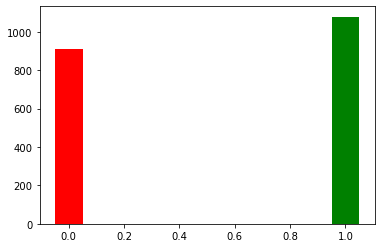

In [60]:
ax = plt.subplot(111)
ax.bar(dow_jones['Label'].unique(), dow_jones['Label'].value_counts(), width=0.1, color=['green','red'])
plt.show()

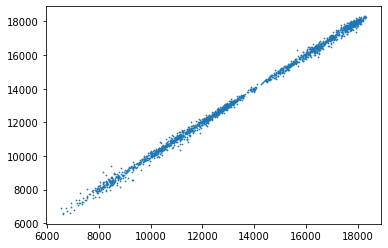

In [61]:
plt.scatter(dow_jones.Open, dow_jones.Close, s = 0.5)

We can see that our labels are quiet well balanced and that there's an expected strong linear correlation between opening DJIA and closening DJIA.

### *Newstitle dataset: explorative data analysis and text preprocessing*

In [62]:
news = pd.read_csv('datasets/RedditNews.csv')

In [63]:
news.head(10)

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
5,2016-07-01,Brazil: Huge spike in number of police killing...
6,2016-07-01,Austria's highest court annuls presidential el...
7,2016-07-01,"Facebook wins privacy case, can track any Belg..."
8,2016-07-01,Switzerland denies Muslim girls citizenship af...
9,2016-07-01,China kills millions of innocent meditators fo...


Now we are just going to check if the dataset is consistent.

In [64]:
news.isna().sum()

Date    0
News    0
dtype: int64

So we can proceed to build a view of the dataset where we group by the date and then build a new feature from joining all the preprocessed newstitles. This function leverages NLTK library and do the whole text-preprocessing: punctuation and stop-words removal, tokenization and stemming. 

In [65]:
def text_preprocesser(text:string)->list:
    tokenized = nltk.word_tokenize(''.join([char 
                                       for char 
                                       in text.lower() 
                                       if char not in string.punctuation]))
                                       
    stop_words = nltk.corpus.stopwords.words('english')
    no_stop_words = [word 
                     for word 
                     in tokenized 
                     if word not in stop_words]

    stemmer = nltk.stem.porter.PorterStemmer()

    return [stemmer.stem(word)
            for word 
            in no_stop_words]

In [66]:
documents = {}
for date in tqdm(news.Date.unique()):
    processed = []
    for text in news.News[news.Date == date]:
        processed += text_preprocesser(text)
    documents[date] = processed

100%|██████████| 2943/2943 [00:38<00:00, 76.18it/s]


In [67]:
newers = pd.DataFrame({'Date':documents.keys(),
                      'Preprocessed News':documents.values()})

In [68]:
newers.head(10)

,Date,Preprocessed News
0,2016-07-01,"[117yearold, woman, mexico, citi, final, recei..."
1,2016-06-30,"[jamaica, propos, marijuana, dispens, tourist,..."
2,2016-06-29,"[explos, airport, istanbul, yemeni, former, pr..."
3,2016-06-28,"[2500, scientist, australia, want, save, great..."
4,2016-06-27,"[barclay, rb, share, suspend, trade, tank, 8, ..."
5,2016-06-26,"[author, raid, 14, scientolog, offic, russia, ..."
6,2016-06-25,"[six, week, rio, olymp, lab, handl, drug, test..."
7,2016-06-24,"[david, cameron, resign, pm, eu, referendum, b..."
8,2016-06-23,"[today, unit, kingdom, decid, whether, remain,..."
9,2016-06-22,"[german, govern, agre, ban, frack, indefinit, ..."


### *Our dataset: joining the previous work into a projection of the data of interest*

In [69]:
final_dataset = dow_jones.merge(newers)
final_dataset = final_dataset.drop(labels=['Open','Close'], axis=1)

In [70]:
final_dataset.head(10)

,Date,Label,Preprocessed News
0,2016-07-01,1,"[117yearold, woman, mexico, citi, final, recei..."
1,2016-06-30,1,"[jamaica, propos, marijuana, dispens, tourist,..."
2,2016-06-29,1,"[explos, airport, istanbul, yemeni, former, pr..."
3,2016-06-28,1,"[2500, scientist, australia, want, save, great..."
4,2016-06-27,0,"[barclay, rb, share, suspend, trade, tank, 8, ..."
5,2016-06-24,0,"[david, cameron, resign, pm, eu, referendum, b..."
6,2016-06-23,1,"[today, unit, kingdom, decid, whether, remain,..."
7,2016-06-22,0,"[german, govern, agre, ban, frack, indefinit, ..."
8,2016-06-21,1,"[australian, athlet, compet, six, paralymp, ga..."
9,2016-06-20,1,"[stagger, 87, percent, venezuelan, say, money,..."


### *Applying Sentiment Analysis to the dataset*

A relationship between breaking news and the stock price has been demonstrated. When breaking news arrives, stock prices will react. This is called Price Discovery.
The type of stock price reaction depends on whether the news is good, bad, or neutral. For investors it is important to have a model that helps them predict how much the market price varies depending on the type of news[1].

Our motivation for conducting sentiment-based text analysis, or opinion mining as it is commonly known, is to determine how neutral the media are in reporting the news and how this neutrality or non-neutrality affects the stock price. 

Sentiment Analisys can help us to determine the mood or emotion in a text. This type of analysis is used to have a better understanding of the text and with this to analyze the impacts they cause.

Firstly, we are going to use TextBlob that is a library for Natural Language Processing(NLP) which performs complex analysis on data. This library use NLTK.
TextBlob will give us back a score of polarity and subjectivity of the text.



- Polarity score will be between -1 and 1, where -1 is a text considered negative and 1 is a text considered positive. In this case -1 will be for bad news and 1 for good news. 
- Subjectivity takes into account the personal and objective opinion contained in the text. Subjectivity score will be between 0 and 1, the closer to 1 the subjectivity is, it implies that the text contains more personal opinion than factual information. [2].

Secondly, we are going to use VADER (Valence Aware Dictionary and sEntiment Reasoner) to obtain the score that represents whether the news is qualified as negative, positive, or neutral. VADER is a rule-based model for sentiment analysys specialized in social media. Several studies have shown that VADER is more sensitive for social media text analysis compared to other models. VADER also takes into consideration word order and degree modifiers [3]. 

Using the scores obtained by VADER and the Polarity and Subjectivity obtained by TextBlob, the classification model will be made.

[1] https://www.bmo.com/main/personal/investments/learning-centre/how-breaking-news-affects-markets/#:~:text=When%20breaking%20news%20comes%20in,price%20movements%20following%20the%20news.

[2] https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

[3] https://www.iaeng.org/publication/IMECS2019/IMECS2019_pp12-16.pdf

To analyze the text, we must convert the Preprocessed News into a string

In [71]:
#converting the words into a list of lists
preprocessed_news_text = final_dataset["Preprocessed News"].values.tolist()

#converting the lists into string to obtain the text
preprocessed_news_text_ = [" ".join(news) for news in preprocessed_news_text]

#converting the final list into a DataFrame
df_string_news = pd.DataFrame(preprocessed_news_text_, columns = ['Preprocessed News Text'])

#Saving the index as a column to merge the two DataFrames
final_dataset.reset_index(inplace=True)
df_string_news.reset_index(inplace=True)

#Merge to obtain the final DataFrame
final_dataset_text = final_dataset.merge(df_string_news, left_on='index', right_on='index')

#Getting just the useful columns
final_dataset_text = final_dataset_text.drop(columns=['Preprocessed News','index'])

In [72]:
final_dataset_text.head(10)

,Date,Label,Preprocessed News Text
0,2016-07-01,1,117yearold woman mexico citi final receiv birt...
1,2016-06-30,1,jamaica propos marijuana dispens tourist airpo...
2,2016-06-29,1,explos airport istanbul yemeni former presid t...
3,2016-06-28,1,2500 scientist australia want save great barri...
4,2016-06-27,0,barclay rb share suspend trade tank 8 pope say...
5,2016-06-24,0,david cameron resign pm eu referendum bbc fore...
6,2016-06-23,1,today unit kingdom decid whether remain europe...
7,2016-06-22,0,german govern agre ban frack indefinit teenag ...
8,2016-06-21,1,australian athlet compet six paralymp game rob...
9,2016-06-20,1,stagger 87 percent venezuelan say money buy en...


### *Subjectivity and Polarity*

In [73]:
from textblob import TextBlob #TextBlob to do the subjectivity and polarily analysis

Defining the functions

In [74]:
def subjectivity_score(news):
    return TextBlob(news).sentiment.subjectivity

def polarity_score(news):
    return TextBlob(news).sentiment.polarity

Creating two new columns 'Subjectivity' and 'Polarity'

In [75]:
final_dataset_text["Subjectivity"] = final_dataset_text["Preprocessed News Text"].apply(subjectivity_score)

final_dataset_text["Polarity"] = final_dataset_text["Preprocessed News Text"].apply(polarity_score)

In [76]:
final_dataset_text.sort_values(by="Subjectivity", ascending=False).head(10)

,Date,Label,Preprocessed News Text,Subjectivity,Polarity
1924,2008-11-07,1,buk judg ask media whether releas guantanamo b...,0.645969,0.091316
1909,2008-12-01,0,bthe uk make offenc punish ten year imprison p...,0.635000,0.026667
1238,2011-08-01,0,murdoch news intern order tech firm massdelet ...,0.618660,-0.231639
1774,2009-06-16,0,byall wan na see femin patriot go iranian woma...,0.594391,-0.170455
1986,2008-08-12,0,brememb ador 9yearold sang open ceremoni fake ...,0.587207,-0.158049
1644,2009-12-18,1,bpragu tv tower world largest spheric rnpanora...,0.572311,-0.005114
1141,2011-12-16,0,christoph hitchen die 62 polic includ occupi m...,0.570412,-0.008460
1304,2011-04-27,1,fatah hama sign reconcili deal palestinian fac...,0.559903,0.144751
1933,2008-10-27,0,bbbc rampant evid georgia commit war crime con...,0.559167,-0.147917
738,2013-07-29,0,saudi princ defect royal famili regim saudi ar...,0.558219,-0.046373


In [77]:
final_dataset_text.sort_values(by="Polarity", ascending=True).head(10)

,Date,Label,Preprocessed News Text,Subjectivity,Polarity
1555,2010-04-29,1,bchina lost 2000 olymp bronz medal gymnast pro...,0.411111,-0.242222
1899,2008-12-15,0,bturk apolog armenian massacr bgreek youth bre...,0.538095,-0.233929
1238,2011-08-01,0,murdoch news intern order tech firm massdelet ...,0.618660,-0.231639
661,2013-11-14,1,indian train strike herd 40 eleph cross track ...,0.421649,-0.219435
1662,2009-11-23,1,bwow turn guy paralyz fulli awar 23 year isnt ...,0.326053,-0.198306
1877,2009-01-16,1,bisra farmer begin feel sting worldwid boycott...,0.250000,-0.196154
1957,2008-09-23,0,bu 13 billion money alloc reconstruct project ...,0.487500,-0.187500
1956,2008-09-24,0,biran leader say american empir near collaps b...,0.510623,-0.177656
1359,2011-02-07,1,einstein right honey bee collaps threaten glob...,0.329073,-0.176031
1774,2009-06-16,0,byall wan na see femin patriot go iranian woma...,0.594391,-0.170455


By organizing the data in ascending order with respect to Polarity, it is possible to see in the first 10 data a relationship between Subjectivity, Polarity and the Label, which is our value of interest. 

As evidenced above, when the Polarity score is negative, that is, it tends to be negative news, and the Subjectivity value is close to 0.5 or higher, which means that the news tends to be subjective, the stock price had a decrease. This analysis is done a priori of the model to show that a logical relationship between the variables exists and therefore, we can have good results with the prediction model.

### *Sentiment Analysis using VADER*

In [78]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #VADER to obtain the sentiment score

Defining the function


In [79]:
def sentiment_score(news):
    sentiment_fun= SentimentIntensityAnalyzer()
    sentiment_value = sentiment_fun.polarity_scores(news)
    return sentiment_value 

SentimentIntensityAnalyzer() is an object and polarity_scores is a method that returns the following scores:
- Positive
- Negative
- Neutral
- Compound

Compound score refers to the sum of positive, negative and neutral scores which is going to be between -1 and 1, -1 to extreme negative and 1 to extreme positive.

Source:
https://analyticsindiamag.com/sentiment-analysis-made-easy-using-vader/#:~:text=The%20compound%20score%20is%20the,the%20positivity%20of%20the%20text.

Getting the sentiment value for each news day and saving the scores previously defined

In [80]:
#Creating lists to save each score
positive = []
negative = []
neutral = []
compound = []

#Applying the funcion to the news.
for news in range (0, len(final_dataset_text["Preprocessed News Text"])):
    sentiment_analysis = sentiment_score(final_dataset_text["Preprocessed News Text"][news])
    positive.append(sentiment_analysis['pos'])
    negative.append(sentiment_analysis['neg'])
    neutral.append(sentiment_analysis['neu'])
    compound.append(sentiment_analysis['compound'])

Assigning each list to a column in the DataFrame

In [81]:
final_dataset_text['Positive'] = positive
final_dataset_text['Negative'] = negative
final_dataset_text['Neutral'] = neutral
final_dataset_text['Compound'] = compound


In [82]:
final_dataset_text.loc[final_dataset_text['Label']==1].sort_values(by="Compound", ascending=False)

,Date,Label,Preprocessed News Text,Subjectivity,Polarity,Positive,Negative,Neutral,Compound
749,2013-07-12,1,canadian win 250000 dollar prize first human p...,0.337478,0.141294,0.129,0.108,0.762,0.8416
410,2014-11-13,1,european robot probe phila made first histor l...,0.370350,0.036657,0.092,0.068,0.841,0.7579
475,2014-08-13,1,south korea firstand onlyastronaut quit job en...,0.419219,0.046327,0.145,0.121,0.734,0.6761
1203,2011-09-20,1,itali propos law ban peopl internet base singl...,0.405455,0.099886,0.111,0.100,0.788,0.6305
1262,2011-06-27,1,video smuggl north korea children beg armi sta...,0.292641,0.013506,0.091,0.080,0.829,0.5591
...,...,...,...,...,...,...,...,...,...
855,2013-02-08,1,egyptian salafi preacher said rape sexual hara...,0.346093,-0.003469,0.004,0.311,0.685,-0.9986
1528,2010-06-08,1,breuter fire remov weapon blood imag gaza flot...,0.355847,-0.019397,0.022,0.272,0.705,-0.9986
1761,2009-07-06,1,buganda outlaw femal circumcis bbreak news 129...,0.319608,-0.137077,0.018,0.355,0.627,-0.9986
888,2012-12-20,1,thiev arrest steal 6 million pound mapl syrup ...,0.333407,-0.031345,0.035,0.272,0.692,-0.9987


In [83]:
final_dataset_text.loc[final_dataset_text['Label']==0].sort_values(by="Compound", ascending=False)

,Date,Label,Preprocessed News Text,Subjectivity,Polarity,Positive,Negative,Neutral,Compound
421,2014-10-29,0,23rd time un nation urg end us embargo cuba sc...,0.408031,0.150026,0.119,0.087,0.794,0.9413
430,2014-10-16,0,wind blow away fossil power nordic baltic next...,0.359074,-0.020185,0.113,0.085,0.802,0.8404
1408,2010-11-26,0,didnt understand quit bad thing becom countri ...,0.427354,0.138759,0.146,0.120,0.734,0.7950
5,2016-06-24,0,david cameron resign pm eu referendum bbc fore...,0.251553,0.073654,0.110,0.093,0.797,0.7351
1686,2009-10-20,0,blegal lobbi grow mexico latin american countr...,0.430745,0.139141,0.157,0.124,0.719,0.7269
...,...,...,...,...,...,...,...,...,...
71,2016-03-22,0,intern crimin court recognis rape war crime fo...,0.368345,0.125624,0.047,0.330,0.623,-0.9985
1238,2011-08-01,0,murdoch news intern order tech firm massdelet ...,0.618660,-0.231639,0.040,0.321,0.639,-0.9986
964,2012-08-30,0,270 south african miner arrest protest charg m...,0.300000,-0.037725,0.060,0.289,0.650,-0.9986
622,2014-01-13,0,broad coalit wellknown organ reddit electron f...,0.310725,0.057825,0.069,0.288,0.643,-0.9987


As expected, in a general view, when the polarity values ​​are negative, the Compound values ​​are also negative indicating that it is bad news and vice versa.

Finally, we save the relevant features of the DataFrame

In [84]:
final_dataset_text = final_dataset_text[['Label','Subjectivity','Polarity','Positive','Negative','Neutral','Compound']]

In [85]:
final_dataset_text.head(10)

,Label,Subjectivity,Polarity,Positive,Negative,Neutral,Compound
0,1,0.323661,0.061161,0.043,0.256,0.701,-0.9983
1,1,0.401465,0.008516,0.076,0.235,0.689,-0.9967
2,1,0.328887,0.096195,0.094,0.174,0.731,-0.9771
3,1,0.322376,0.047233,0.098,0.100,0.802,-0.2263
4,0,0.240160,0.012517,0.084,0.149,0.767,-0.9670
5,0,0.251553,0.073654,0.110,0.093,0.797,0.7351
6,1,0.234091,0.037582,0.061,0.192,0.747,-0.9922
7,0,0.233530,0.047970,0.069,0.126,0.805,-0.9799
8,1,0.218855,0.014268,0.071,0.232,0.697,-0.9972
9,1,0.381348,0.101738,0.054,0.233,0.713,-0.9980


### *Linear Discriminant Analysis Model*

Linear Discriminant Analysis (LDA) is a method from multivariate statistics which principal objective is to find a
linear projection of high-dimensional observations into a lower-dimensional space. When your preconditions are met, LDA allows you to define optimal linear decision bounds on the
resulting latent space [4].

In other words, Linear Discriminant Analysis is a linear classification algorithm, like logistic regression. The algorithm develops a probabilistic model by class based on the distribution of observations for each input variable [5]. 

In this way, the data is classified by getting the conditional probability of it belonging to each class and the class with the highest probability is chosen. This means that LDA can be considered as an application of the Bayes Theorem for classification. 

This model assumes that the input variables are numeric, normally distributed and that they have the same variance. Also, it assumes that the input variables are not correlated. Therefore, this model makes strong assumptions about the distribution of each input variable [5].

LDA is naturally multi-class, so it supports two-class classification problems, such as our case of study [5].

Our motivation in selecting this simple model is to analyze the behavior and the results obtained from it after making all the assumptions described above and reinforcing the adjustment of the hyperparameters with PCA (to reduce dimensionality and correlation) and cross validation.


[4] https://arxiv.org/pdf/1511.04707.pdf

[5] https://machinelearningmastery.com/linear-discriminant-analysis-with-python/

### *Principal Component Analysis*

PCA (Principal Component Analysys) is one of the most common linear algorithms for dimensionality reduction used in unsupervised learning. This algorithm identifies and removes variables that are less useful for making a valid approximation on a data set [6].

PCA is very useful in our case study for two reasons: It helps us to identify the variables that are correlated between them and to reduce the risk of the LDA falling into parameter overfitting, which is very common.

Finally, it has been demonstrated in multiple studies that performing PCA prior LDA leads to a better fit and performance of the model [7].

[6] https://www.jcchouinard.com/pca-with-python/

[7] https://www.sciencedirect.com/science/article/abs/pii/S0031320302000481



Loading features and target separately

In [86]:
X = final_dataset_text

X = np.array(X.drop(['Label'], 1))

/var/folders/gy/6j7jtq4n7m36jvtq0tfc4t880000gn/T/ipykernel_6378/4239202178.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(['Label'], 1))


In [87]:
y = np.array(final_dataset_text['Label'])

Standarizing features by removing mean and scaling to unite variance.

The standard score of a sample is calculated as:

$$ z = \frac{x-u}{s}\\ $$

where u is the mean of the traning samples and s is the standard deviation of the training samples.

Standarization of the dataset is a common requirment to for modeling the data. In the case of LDA it is not necessary because LDA results will be the same whether or not the data is standardized. However, it is a good practice to do it in the pre-processing data of a model which assumes that its features have a Gaussian distribution.

In [88]:
from sklearn.preprocessing import StandardScaler

x_scaled = StandardScaler().fit_transform(X)

Our dataset contains 6 features (6-dimensional dataset). Not all features will be required for the classification task. The noisy features are going to be removed and then, a faster model is going to be generated.

In [118]:
from sklearn.decomposition import PCA 

#Reducing the number of features to 4 
pca = PCA(n_components=4)

#Fit the model 
pca_features = pca.fit_transform(x_scaled)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3', 'PC4'])

Joining the target to the PC (Principal Components)

In [119]:
pca_df['Label'] = y

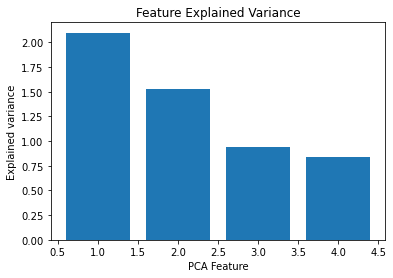

In [120]:
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

As evidenced in the figure obtained, the PC3 and PC4 don't have much relevance in the target. Since we know that LDA is also a dimensionality reducer, we jointly define leaving all the features obtained and performing the LDA with them.

In [121]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #Import LDA

model_1 = LinearDiscriminantAnalysis() #create the model for data with PCA applied
model_1.fit(pca_features, y)

model_2 =  LinearDiscriminantAnalysis() #create the model for data without PCA applied
model_2.fit(x_scaled, y)


LinearDiscriminantAnalysis()

We evaluate the LDS using k-fold cross-validation with RepeatedStratifiedKFold class. We are going to use 10 folds and 3 repeats in the test.

Evaluation of the PCA + LDA

In [122]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

#Evaluation method
cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluating the model
scores = cross_val_score(model_1, pca_features, y, scoring='accuracy', cv=cross_validation, n_jobs=-1)

#Result
print('Model Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Model Mean Accuracy: 0.540 (0.005)


Evaluation of just LDA

In [123]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

#Evaluation method
cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#Evaluating the model
scores = cross_val_score(model_2, x_scaled, y, scoring='accuracy', cv=cross_validation, n_jobs=1)

#Result
print('Model Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Model Mean Accuracy: 0.539 (0.007)


We can see that the model performed a mean accuracy of 54.0% with PCA+LDA and with a mean accuracy od 53.9% with just LDA. In addition, it was observed that the processing time of the model was very similar. Therefore, it is concluded that for our classification model it is not convenient to use Linear Discrimant Analysis, since it will have a very low percentage of precision whether or not PCA is used before LDA.

It is also important to highlight that perhaps the vectorization of the news using Sentiment Analysis influenced the percentage of accuracy of the model. 

As future work there are 2 possible options that can increase the accuracy obtained:
1. Use another vectorization, such as TF-IDF, word2vec or GloVe.
2. Include the data that was considered not important to carry out the analysis of the model. (High, Low, Volume, Adj Close).